# Constructing Enterprise KGs from tabular data

An **enterprise knowledge graph** is a graph that represents entities and their relationships that are relevant to the enterprise. 

An Enterprise KG is typically the result of integrating information about the same entities from different data sources, such as ERP and CRM systems and the Web.

The main requirements are
- global identifiers for entities (to combine information from different sources)
- global vocabulary to talk about relationships and attributes 
- to allow incomplete and heterogeneous information  


Relational databases are suitable for representing highly structured, homogeneous and complete information (as in ERP systems). 

- Knowledge Graphs (KGs) are typically constructed from other data sources
- RDF is typically not the native form of the data
- RDF is very handy for data integration

This notebook demonstrates the construction of knowledge graphs from tabular data. 

In this course we do not cover the whole data integration chain (extract-transform-load, see data warehousing) which involves a lot of effort in data cleaning, entity resolution, ...

The tabular data we use as starting point are extracted from the enterprise database or are the result of prior data integration steps or are manually maintained in an integrated fashion. We are using global identifiers for entities and global identifiers for columns (representing properties). 

Here we only cover one step in the data integration process, namely the transformation of tabular data to RDF which facilitates otherwise complex queries. 

We make use of the following Python libraries:
- rdflib: to create and query RDF graphs
- pydot: to visualize (simple) RDF graphs 

For didactic reasons, in this course, we keep examples small and do everything in Python using off-the-shelf Python libraries and open standardized languages (RDF, SPARQL). This is to give students full control to toy around with  program and data without keeping anything out of sight and to allow reuse (by clone-and-own) for own experiments. 

Keep in mind that for building and maintaining an *Enterprise Knowledge Graph* one may want to use a knowledge graph management platform and dedicated mapping technologies to handle higher volume and variety of data and to manage the scripts, schemas, data and vocabularies that constitute the enterprise knowledge graph. 

## 1. Install rdflib and pydot

In [ ]:
# Install required packages in the current Jupyter kernel
!pip install -q rdflib 
!pip install -q pydot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.3/500.3 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 KB 2.4 MB/s eta 0:00:00


# 2. Import rdflib, pydot

In [ ]:
from rdflib import Graph, Literal, RDF, URIRef, BNode, Namespace, Dataset
from rdflib.namespace import FOAF , XSD , RDFS 
from IPython.display import Image
import pydot
from tabulate import tabulate

# Custom functions for transforming tabular data to RDF and visualizing RDF

In [ ]:
def table2rdf(table,graph):
  for i in range(len(table)):
    if(i==0): continue
    subj= table[i][0]
    for j in range(len(table[i])):
      if(j==0): continue  
      prop = table[0][j]
      obj = table[i][j]
      if(obj!=None): 
        if(type(obj)!=URIRef): obj = Literal(obj)
        graph.add((subj, table[0][j], obj))


def prettyTable(table,graph):
  str_table = []
  for row in table:
    str_row = []
    for val in row:
      if(type(val)==URIRef): val=val.n3(graph.namespace_manager)
      str_row.append(val)
    str_table.append(str_row)
  return tabulate(str_table, tablefmt="simple", headers="firstrow")+"\n"


def create_png(g, filename):

  def node_id(g,t):
    if isinstance(t,URIRef):
      return f"\"{t.n3(g.namespace_manager)}\""
    if isinstance(t,Literal):
      return t.n3(g.namespace_manager)
    if isinstance(t,BNode):
      return f"\"{t.n3(g.namespace_manager)}\""

  dg = pydot.Dot('my_graph', 
                graph_type='digraph', 
                bgcolor='white', 
                layout='sfdp', 
                splines='curved' 
                )

  node_query = """
  SELECT DISTINCT ?node
  WHERE {
    { ?node ?p ?o . } UNION { ?s ?p ?node}
  }"""

  qres = g.query(node_query)
  for row in qres:
    t = row.node
    if isinstance(t,URIRef):
      dg.add_node(pydot.Node( node_id(g,t), label=f"\"{t.n3(g.namespace_manager)}\"" ))
    if isinstance(t,Literal):
      dg.add_node(pydot.Node( node_id(g,t), label=t.n3(g.namespace_manager), shape="box"))
    if isinstance(t,BNode):
      dg.add_node(pydot.Node( node_id(g,t), label=""))

  for (s,p,o) in g:
    dg.add_edge(pydot.Edge( 
        node_id(g,s), 
        node_id(g,o), 
        label=f"\"{p.n3(g.namespace_manager)}\""))

  dg.write_png(filename)

# Create namespaces together with an empty RDF graph to manage namespaces
The purpose of this graph is to have reusable namespace manager

In [ ]:
V = Namespace("http://ex.org/vocabulary/")
E = Namespace("http://ex.org/entity/")
empty = Graph()
empty.bind("v",V)
empty.bind("e",E)
empty.bind("foaf",FOAF)

# Example: a social network


----- TABULAR DATA ------

ID    v:name        v:age
----  ----------  -------
e:p1  Jim Jarvis       27
e:p2                   43
e:p3  Jane Joper

ID    foaf:knows
----  ------------
e:p1  e:p2
e:p1  e:p3
e:p3  e:p1


----- RDF GRAPH (in Turtle Format) ------

@prefix e: <http://ex.org/entity/> .
@prefix foaf: <http://xmlns.com/foaf/0.1/> .
@prefix v: <http://ex.org/vocabulary/> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

e:p1 v:age 27 ;
    v:name "Jim Jarvis" ;
    foaf:knows e:p2,
        e:p3 .

e:p2 v:age 43 .

e:p3 v:name "Jane Joper" ;
    foaf:knows e:p1 .



----- Visualization of RDF GRAPH ------



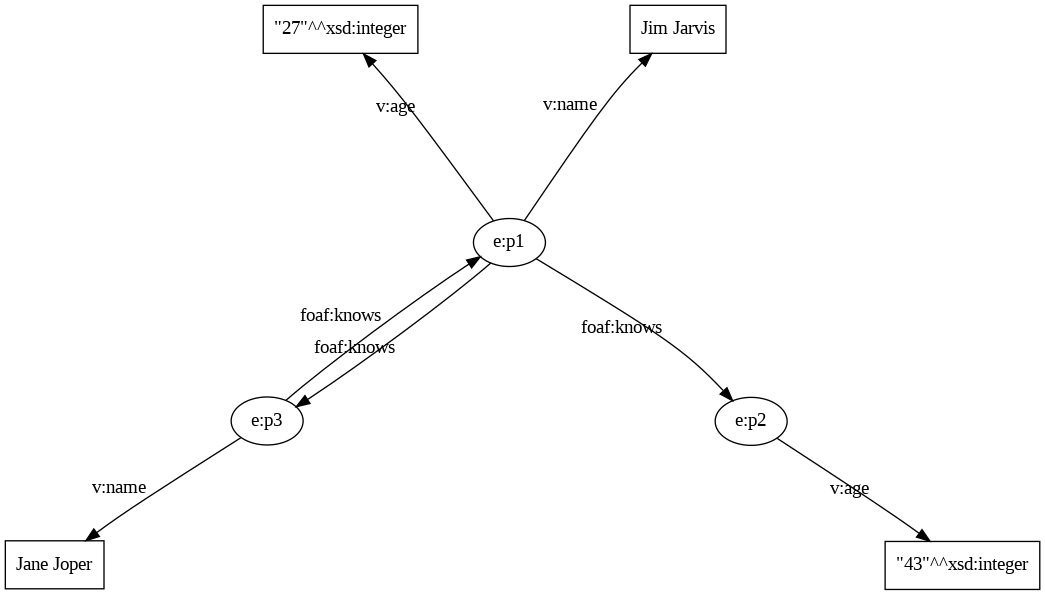

In [ ]:
person = [
  ["ID",V.name,V.age],
  [E.p1, "Jim Jarvis", 27],
  [E.p2, None, 43],
  [E.p3, "Jane Joper", None]
]

knows = [
    ["ID",FOAF.knows],
    [E.p1, E.p2],
    [E.p1, E.p3],
    [E.p3, E.p1]
]

tables = [person, knows]

# Create a new RDF graph that reuses the namespaces of the empty RDF graph
g = Graph(namespace_manager = empty.namespace_manager)

for table in tables:
  table2rdf(table,g)

print("\n----- TABULAR DATA ------\n")
for table in tables:
  print(prettyTable(table,g))

print("\n----- RDF GRAPH (in Turtle Format) ------\n")
print(g.serialize(format='turtle'))

print("\n----- Visualization of RDF GRAPH ------\n")
create_png(g,'output.png')
Image('output.png')

# Example: Customer relationships between companies 


----- TABULAR DATA ------

ID         v:name                           v:noOfEmployees
---------  -----------------------------  -----------------
e:oebb     Oesterreichische Bundesbahnen              41904
e:siemens  Siemens AG                                311000
e:stadler  Stadler Rail AG                            12303

ID              v:roleOf    v:customerOf      v:salesVolume
--------------  ----------  --------------  ---------------
e:oebb_siemens  e:oebb      e:siemens              32300000
e:oebb_stadler  e:oebb      e:stadler               8921201


----- RDF GRAPH (in Turtle Format) ------

@prefix e: <http://ex.org/entity/> .
@prefix v: <http://ex.org/vocabulary/> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

e:oebb_siemens v:customerOf e:siemens ;
    v:roleOf e:oebb ;
    v:salesVolume 32300000 .

e:oebb_stadler v:customerOf e:stadler ;
    v:roleOf e:oebb ;
    v:salesVolume 8921201 .

e:siemens v:name "Siemens AG" ;
    v:noOfEmployees 311000 .

e:stadler v

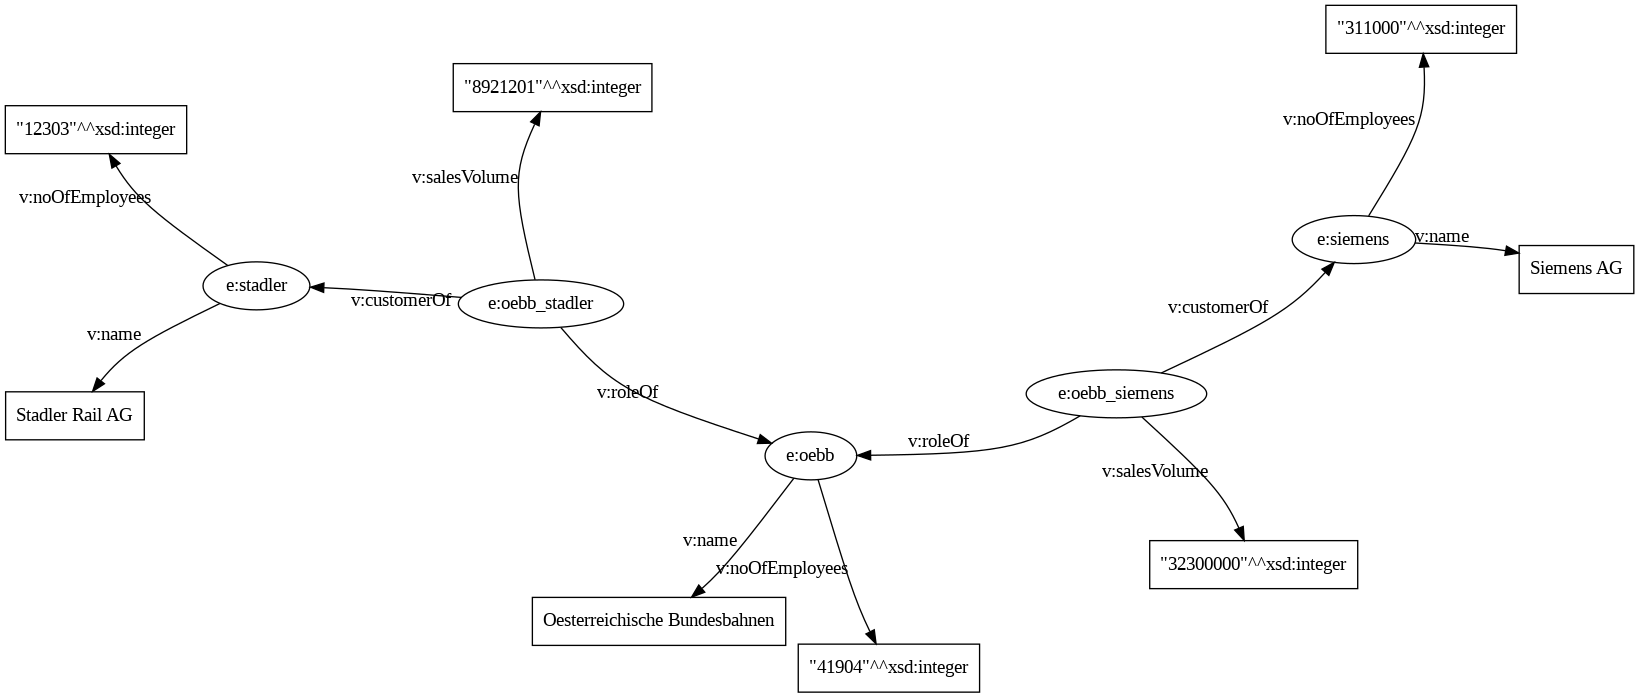

In [ ]:
companies = [
  ["ID", V.name, V.noOfEmployees],
  [E.oebb, "Oesterreichische Bundesbahnen", 41904],
  [E.siemens, "Siemens AG", 311000],
  [E.stadler, "Stadler Rail AG", 12303]
]

customer = [
  ["ID", V.roleOf, V.customerOf,V.salesVolume],
  [E.oebb_siemens, E.oebb, E.siemens, 32300000],
  [E.oebb_stadler, E.oebb, E.stadler, 8921201]
]

tables = [companies,customer]

# Create a new RDF graph that reuses the namespaces of the empty RDF graph
g = Graph(namespace_manager = empty.namespace_manager)

for table in tables:
  table2rdf(table,g)

print("\n----- TABULAR DATA ------\n")
for table in tables:
  print(prettyTable(table,g))

print("\n----- RDF GRAPH (in Turtle Format) ------\n")
print(g.serialize(format='turtle'))

print("\n----- Visualization of RDF GRAPH ------\n")
create_png(g,'output.png')
Image('output.png')

## Use SPARQL to query companies and customer relationships

In [ ]:
# we can reuse the namespace prefixes defined with the graph

query = """
SELECT ?company_name ?customerOf_name ?salesVolume 
WHERE { 
  ?customer 
    v:roleOf/v:name ?company_name ; 
    v:customerOf/v:name ?customerOf_name; 
    v:salesVolume ?salesVolume. 
}"""

result = g.query(query)

print(result.serialize(format='txt',namespace_manager=g.namespace_manager).decode())

query = """
SELECT ?company ?customerOf ?salesVolume 
WHERE { 
  ?customer 
    v:roleOf ?company ; 
    v:customerOf ?customerOf; 
    v:salesVolume ?salesVolume. 
}"""

result = g.query(query)

print(result.serialize(format='txt',namespace_manager=g.namespace_manager).decode())

         company_name          | customerOf_name |      salesVolume      
--------------------------------------------------------------------------
"Oesterreichische Bundesbahnen"|"Siemens AG"     |"32300000"^^xsd:integer
"Oesterreichische Bundesbahnen"|"Stadler Rail AG"|"8921201"^^xsd:integer 

company|customerOf|      salesVolume      
-----------------------------------------
e:oebb|e:siemens|"32300000"^^xsd:integer
e:oebb|e:stadler|"8921201"^^xsd:integer 



# Example: Windsors


----- TABULAR DATA ------

ID            v:mother      v:father
------------  ------------  ----------
e:Elizabeth2                e:George6
e:Charles     e:Elizabeth2  e:Philip
e:William     e:Diana       e:Charles
e:Harry       e:Diana       e:Charles
e:George      e:Kate        e:William


----- RDF GRAPH (in Turtle Format) ------

@prefix e: <http://ex.org/entity/> .
@prefix v: <http://ex.org/vocabulary/> .

e:George v:father e:William ;
    v:mother e:Kate .

e:Harry v:father e:Charles ;
    v:mother e:Diana .

e:Elizabeth2 v:father e:George6 .

e:William v:father e:Charles ;
    v:mother e:Diana .

e:Charles v:father e:Philip ;
    v:mother e:Elizabeth2 .



----- Visualization of RDF GRAPH ------



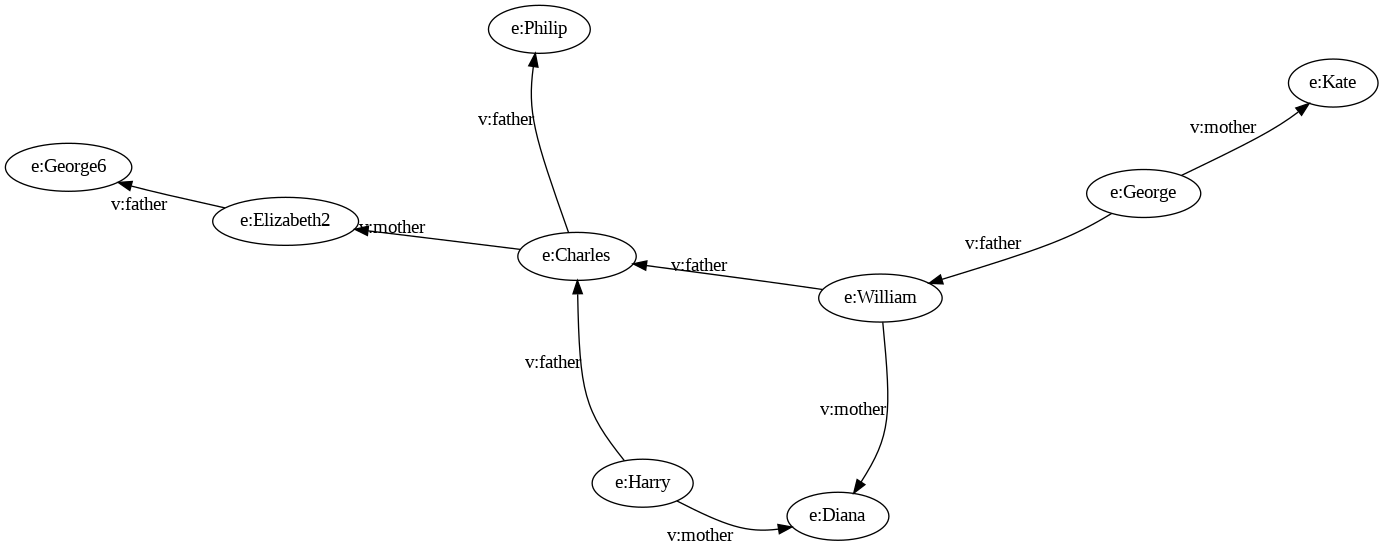

In [ ]:
windsors = [
  ["ID", V.mother, V.father],
  [E.Elizabeth2, None, E.George6],
  [E.Charles, E.Elizabeth2, E.Philip],
  [E.William, E.Diana, E.Charles],
  [E.Harry, E.Diana, E.Charles],
  [E.George, E.Kate, E.William],
]

tables = [windsors]

# Create a new RDF graph that reuses the namespaces of the empty RDF graph
g = Graph(namespace_manager = empty.namespace_manager)

for table in tables:
  table2rdf(table,g)

print("\n----- TABULAR DATA ------\n")
for table in tables:
  print(prettyTable(table,g))

print("\n----- RDF GRAPH (in Turtle Format) ------\n")
print(g.serialize(format='turtle'))

print("\n----- Visualization of RDF GRAPH ------\n")
create_png(g,'output.png')
Image('output.png')

In [ ]:
query = """
SELECT ?ancestor_of_george 
WHERE { 
   e:George (v:mother|v:father)+ ?ancestor_of_george . 
}"""

result = g.query(query)
print(result.serialize(format='txt',namespace_manager=g.namespace_manager).decode())

ancestor_of_george
-------------
e:Charles   
e:Diana     
e:Elizabeth2
e:George6   
e:Kate      
e:Philip    
e:William   

